In [169]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import surface_code_opt as sc
import itertools

# The data for all the figures

这里统一说明参数的命名以及取值

    命名规则：
        N：表示matrix size
        s：表示sparsity
        k: 表示condition number
        \(\epsilon\)：表示误差

对于折线图，统一假设s=k=log2(N)，对于热力图，统一参数设置下面代码所示

In [170]:
max_physical_qubits = np.inf
physical_error_rate = 1e-5
clock_cycle_time = 1e-8
precision = 4

fix_k = 10
fix_s = 100
fix_epsilon_inv = 100
s_start, s_end, ds = 10, 50, 1
k_start, k_end, dk = 5, 20, 1
epsilon_inv_start, epsilon_inv_end, depslilon_inv = 10, 200, 1

# Runtime

We first define the formula for calculating quantum runtime and classical runtime.

In [171]:
def calculate_q_runtime(k, s, epsilon_inv, N):
    epsilon = 1 / np.array(epsilon_inv)
    n = np.log2(N)

    def calculate_each(k, s, epsilon, n):

        hhl_task = sc.HHL(n, s, k, epsilon, precision)
        (_, _, optimal_cycle_count, _) = sc.find_optimal_setting(
            hhl_task.t_gate_count,
            hhl_task.logical_qubit_count,
            physical_error_rate,
            max_physical_qubits,
        )
        return optimal_cycle_count * clock_cycle_time

    def process_inputs(*args):
        if isinstance(args[0], tuple):
            grids = args
            coords = np.stack(grids, axis=-1).reshape(-1, len(grids))
            results = [calculate_each(*point) for point in coords]
            return np.array(results).reshape(grids[0].shape)
        else:
            return np.vectorize(calculate_each)(*args)

    return process_inputs(k, s, epsilon, n)

def calculate_q_space(k, s, epsilon_inv, N):
    epsilon = 1 / np.array(epsilon_inv)
    n = np.log2(N)

    def calculate_each(k, s, epsilon, n):

        hhl_task = sc.HHL(n, s, k, epsilon, precision)
        (_, _, _, phy_qubit_count) = sc.find_optimal_setting(
            hhl_task.t_gate_count,
            hhl_task.logical_qubit_count,
            physical_error_rate,
            max_physical_qubits,
        )
        return phy_qubit_count 

    def process_inputs(*args):
        if isinstance(args[0], tuple):
            grids = args
            coords = np.stack(grids, axis=-1).reshape(-1, len(grids))
            results = [calculate_each(*point) for point in coords]
            return np.array(results).reshape(grids[0].shape)
        else:
            return np.vectorize(calculate_each)(*args)

    return process_inputs(k, s, epsilon, n)
# k: 56, epsilon_inv: 100, N: 72057594037927936, s: 56


def calculate_c_runtime(k, s, epsilon_inv, N):
    # Conjugate Gradient method 
    # see the paper for the derivation of this formula
    flops = 0.5 * k * np.log(2 * epsilon_inv) * (4 * N * s + 14 * N)
    # CG method is not parallelizable, so we need to divide the flops by the one cpu frequency
    cpu_frequency = 1e9
    return flops / cpu_frequency

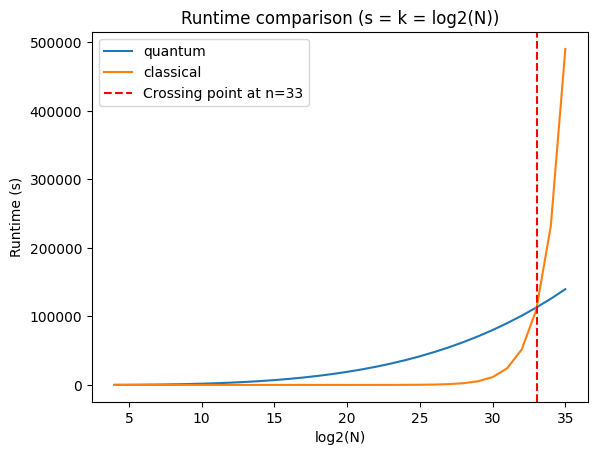

In [172]:
def plot_runtime_line_graph():
    n_start = 4
    n_end =36

    n = np.arange(n_start, n_end, 1)
    k = n
    s = n
    epsilon_inv  = np.full(len(k), fix_epsilon_inv)

    q_runtime = calculate_q_runtime(k, s, epsilon_inv, 2**n)
    c_runtime = calculate_c_runtime(k, s, epsilon_inv, 2**n)

    fig, ax = plt.subplots()
    ax.plot(n, q_runtime, label="quantum")
    ax.plot(n, c_runtime, label="classical")

    # Find the crossing point
    crossing_index = np.where(np.diff(np.sign(q_runtime - c_runtime)))[0][0]
    crossing_n = n[crossing_index] + (c_runtime[crossing_index] - q_runtime[crossing_index]) / (q_runtime[crossing_index + 1] - q_runtime[crossing_index] - c_runtime[crossing_index + 1] + c_runtime[crossing_index])

    # Mark the crossing point
    ax.axvline(x=crossing_n, color='r', linestyle='--', label=f'Crossing point at n={int(crossing_n)}')

    ax.set_xlabel("log2(N)")
    ax.set_ylabel("Runtime (s)")
    ax.set_title("Runtime comparison (s = k = log2(N))")
    ax.legend()
    fig.savefig("runtime_line.pdf")
    plt.show()

plot_runtime_line_graph()

(41, 23) (41, 23)
N_steps: 23


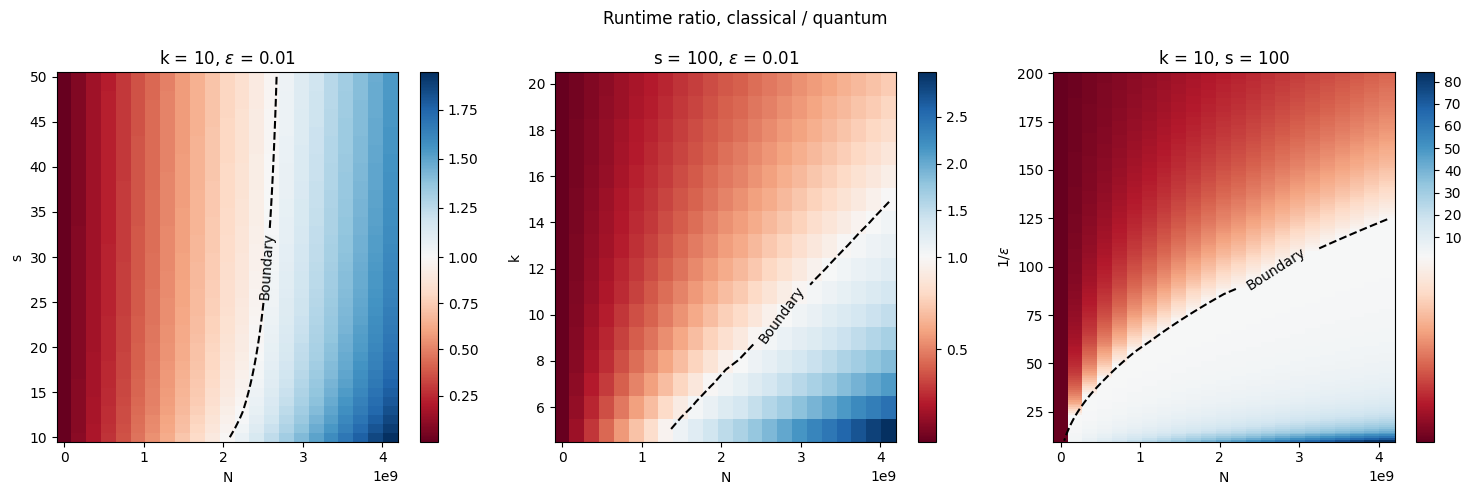

In [173]:
def sub_plot(fig, ax, x,y, data, title, xlabel, ylabel):
    norm = colors.TwoSlopeNorm(vmin=data.min(), vcenter=1, vmax=data.max())
    c = ax.pcolor(x, y, data, cmap="RdBu", norm=norm)
    ax.set_title(title)
    fig.colorbar(c, ax=ax)   

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    contour = ax.contour(
        x,
        y,
        data,
        levels=[1],
        colors="black",
        linewidths=1.5,
        linestyles="--",
    )
    ax.clabel(contour, fmt="Boundary", fontsize = 10,colors="black")

def calculate_ratio(q_runtime, c_runtime, N, n_start):
    ratio = c_runtime
    for i in range(0, N.shape[0]):
        for j in range(0, N.shape[1]):
            q_j= np.floor(np.log2(N[i, j])).astype(int) - n_start
            ratio[i, j] = ratio[i, j] / q_runtime[i, q_j]
    return ratio


def plot_runtime_heatmap():  # set this function to avoid conflict variables
    n_start, n_end, dn = 10, 32, 1

    # big N used by classical plot
    N_start = 2**n_start
    N_end = 2**n_end
    N_steps = n_end - n_start + 1
    dN = (N_end - N_start) / N_steps

    fig, axs = plt.subplots(1,3,figsize=(15, 5))

    ###############################
    # n - s
    ###############################
    s, n = np.mgrid[s_start : s_end + ds : ds, n_start : n_end + dn : dn]
    _, n_s_N = np.mgrid[s_start : s_end + ds : ds, N_start : N_start + N_steps * dN : dN]

    n_s_q_runtime = calculate_q_runtime(fix_k, s, fix_epsilon_inv, 2**n)
    print(s.shape, n_s_N.shape)
    print("N_steps:",  N_steps)
    n_s_c_runtime = calculate_c_runtime(fix_k, s, fix_epsilon_inv, n_s_N)
    n_s_ratio = calculate_ratio(n_s_q_runtime, n_s_c_runtime, n_s_N, n_start)

    sub_plot(fig, axs[0], n_s_N, s, n_s_ratio, f"k = {fix_k}, $\\epsilon$ = {1/fix_epsilon_inv}", "N", "s")

    ###############################
    # k - n
    ###############################
    k, n = np.mgrid[k_start : k_end + dk : dk, n_start : n_end + dn : dn]
    _, n_k_N = np.mgrid[k_start : k_end + dk : dk, N_start : N_start + N_steps * dN  :  dN]
    n_k_q_runtime = calculate_q_runtime(k, fix_s, fix_epsilon_inv, 2**n)
    n_k_c_runtime = calculate_c_runtime(k, fix_s, fix_epsilon_inv, n_k_N)
    n_k_ratio = calculate_ratio(n_k_q_runtime, n_k_c_runtime, n_k_N, n_start)

    sub_plot(fig,axs[1], n_k_N, k, n_k_ratio, f"s = {fix_s}, $\\epsilon$ = {1/fix_epsilon_inv}", "N", "k")

    ###############################
    # epsilon - n
    ###############################
    
    epsilon, n = np.mgrid[epsilon_inv_start : epsilon_inv_end + depslilon_inv : depslilon_inv, n_start : n_end + dn : dn]
    _, n_epsilon_N = np.mgrid[epsilon_inv_start : epsilon_inv_end + depslilon_inv : depslilon_inv,  N_start : N_start + N_steps * dN : dN]
    n_epsilon_q_runtime = calculate_q_runtime(fix_k, fix_s, epsilon, 2**n)
    n_epsilon_c_runtime = calculate_c_runtime(fix_k, fix_s, epsilon, n_epsilon_N)
    n_epsilon_ratio = calculate_ratio(n_epsilon_q_runtime, n_epsilon_c_runtime, n_epsilon_N, n_start)

    sub_plot(fig, axs[2], n_epsilon_N, epsilon, n_epsilon_ratio, f"k = {fix_k}, s = {fix_s}", "N", "$1 / \\epsilon$")
    fig.suptitle("Runtime ratio, classical / quantum")
    plt.tight_layout()

    plt.show()


plot_runtime_heatmap()

# Energy
We estimate the quantum energy using a simple formula: "q_energy = runtime * physical_qubit_count * power_per_physical_qubit".

We estimate the classical energy using a simple formula: "c_energy = runtime * cpu_power"

In [174]:
def calculate_q_energy(k,s,epsilon_inv,N):
    # physical_qubit_count = 150000 + 2500 * np.log2(N)  # numerically estimated using qsharp resource estimator
    physical_qubit_count = 4375 * np.log2(N) + 31250 # numerically estimated using my estimator
    runtime = calculate_q_runtime(k, s, epsilon_inv, N)
    power_per_physical_qubit = 6.25  # 6.25 Watts very rough estimate by "Estimating the Energy Requirements to  Operate a Cryptanalytically Relevant  Quantum Computer"
    
    return  physical_qubit_count * runtime * power_per_physical_qubit

def calculate_c_energy(k,s,epsilon_inv,N):
    # runtime = calculate_c_runtime(k, s, epsilon_inv, N)
    flops = 0.5 * k * np.log(2 * epsilon_inv) * (4 * N * s + 14 * N)
    # CG method is not parallelizable, so we need to divide the flops by the one cpu frequency
    cpu_frequency = 1e9
    runtime = flops / cpu_frequency
    power = 50 # suppose the classical cpu power is 50 Watts  
    return runtime * power

In [175]:
def calculate_log_q_energy(k, s, epsilon_inv, N):
    return np.log10(calculate_q_energy(k, s, epsilon_inv, N))

def calculate_log_c_energy(k, s, epsilon_inv, N):
    return np.log10(calculate_c_energy(k, s, epsilon_inv, N))

def calculate_log_ratio(q_data, c_data,N, n_start):
    # return 10**(c_energy - q_energy)

    ratio = c_data
    for i in range(0, N.shape[0]):
        for j in range(0, N.shape[1]):
            q_j= np.floor(np.log2(N[i, j])).astype(int) - n_start
            ratio[i, j] = 10**( ratio[i, j] - q_data[i, q_j])
    return ratio

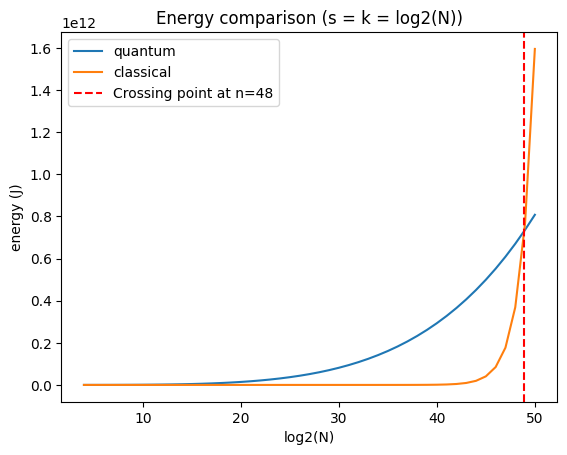

In [176]:
def plot_energy_line_graph():

    n_start = 4
    n_end = 51

    n = np.arange(n_start, n_end, 1)
    k = n
    s = n
    
    q_energy = calculate_q_energy(k, s, fix_epsilon_inv, 2**n)
    c_energy = []
    for i in range(n_start, n_end):
        c_energy.append(calculate_c_energy(int(k[i - n_start]), int(s[i - n_start]), fix_epsilon_inv, 2**i))
    
    fig, ax = plt.subplots()
    ax.plot(n, q_energy, label="quantum")
    ax.plot(n, c_energy, label="classical")

    # Find the crossing point
    crossing_index = np.where(np.diff(np.sign(q_energy - c_energy)))[0][0]
    crossing_n = n[crossing_index] + (c_energy[crossing_index] - q_energy[crossing_index]) / (q_energy[crossing_index + 1] - q_energy[crossing_index] - c_energy[crossing_index + 1] + c_energy[crossing_index])

    # Mark the crossing point
    ax.axvline(x=crossing_n, color='r', linestyle='--', label=f'Crossing point at n={int(crossing_n)}')

    ax.set_xlabel("log2(N)")
    ax.set_ylabel("energy (J)")
    ax.legend()
    ax.set_title("Energy comparison (s = k = log2(N))")
    fig.savefig("energy_line.pdf")
    plt.show()

plot_energy_line_graph()

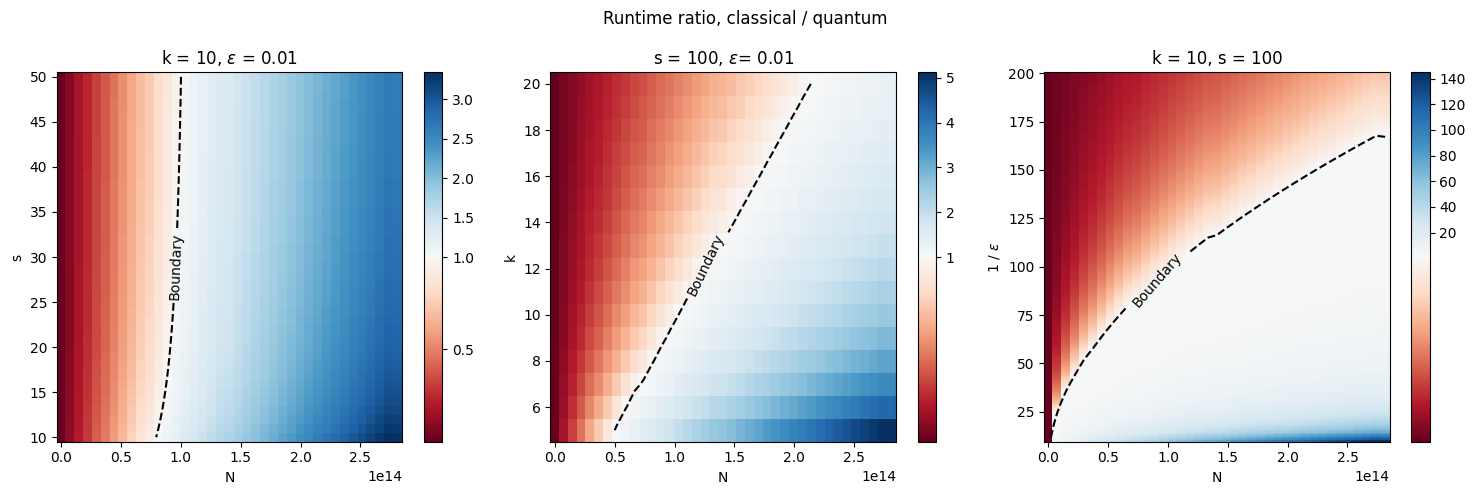

In [177]:
def plot_energy_heatmap():  # set this function to avoid conflict variables

    n_start, n_end, dn = 10, 48, 1

    # big N used by classical plot
    N_start = 2**n_start
    N_end = 2**n_end
    N_steps = n_end - n_start
    dN = (N_end - N_start) / N_steps

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    ###############################
    # n - s
    ###############################
    s, n = np.mgrid[s_start : s_end + ds : ds, n_start : n_end + dn : dn]
    _, n_s_N = np.mgrid[s_start : s_end + ds : ds, N_start : N_end + dN : dN]

    n_s_q_energy = calculate_log_q_energy(fix_k, s, fix_epsilon_inv, 2**n)
    n_s_c_energy = calculate_log_c_energy(fix_k, s, fix_epsilon_inv, n_s_N)
    n_s_ratio = calculate_log_ratio(n_s_q_energy, n_s_c_energy, n_s_N, n_start)
    
    assert n_s_ratio.max() > 1 
    
    
    sub_plot(
        fig,
        axs[0],
        n_s_N,
        s,
        n_s_ratio,
        f"k = {fix_k}, $\\epsilon$ = {1/fix_epsilon_inv}",
        "N",
        "s",
    )

    ###############################
    # k - n
    ###############################
    k, n = np.mgrid[k_start : k_end + dk : dk, n_start : n_end + dn : dn]
    _, n_k_N = np.mgrid[k_start : k_end + dk : dk, N_start : N_end + dN : dN]
    n_k_q_energy = calculate_log_q_energy(k, fix_s, fix_epsilon_inv, 2**n)
    n_k_c_energy= calculate_log_c_energy(k, fix_s, fix_epsilon_inv, n_k_N)
    n_k_ratio = calculate_log_ratio(n_k_q_energy, n_k_c_energy, n_k_N, n_start)
   

    sub_plot(
        fig,
        axs[1],
        n_k_N,
        k,
        n_k_ratio,
        f"s = {fix_s}, $\\epsilon$= {1/fix_epsilon_inv}",
        "N",
        "k",
    )

    ###############################
    # epsilon - n
    ###############################

    epsilon, n = np.mgrid[
        epsilon_inv_start : epsilon_inv_end + depslilon_inv : depslilon_inv,
        n_start : n_end + dn : dn,
    ]
    _, n_epsilon_N = np.mgrid[
        epsilon_inv_start : epsilon_inv_end + depslilon_inv : depslilon_inv,
        N_start : N_end + dN : dN,
    ]
    n_epsilon_q_energy = calculate_log_q_energy(fix_k, fix_s, epsilon, 2**n)
    n_epsilon_c_energy= calculate_log_c_energy(fix_k, fix_s, epsilon, n_epsilon_N)
    n_epsilon_ratio = calculate_log_ratio(
        n_epsilon_q_energy, n_epsilon_c_energy, n_epsilon_N, n_start
    )

    sub_plot(
        fig,
        axs[2],
        n_epsilon_N,
        epsilon,
        n_epsilon_ratio,
        f"k = {fix_k}, s = {fix_s}",
        "N",
        "1 / $\\epsilon$",
    )

    fig.suptitle("Runtime ratio, classical / quantum")
    plt.tight_layout()

    plt.show()


plot_energy_heatmap()

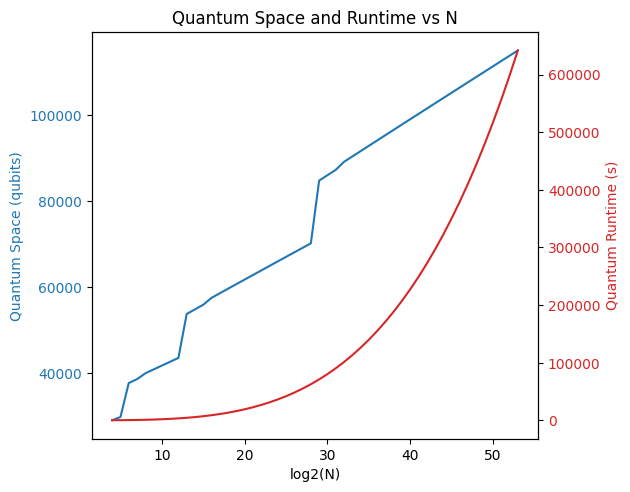

In [178]:
def plot_space_time_line_graph():

    n_start = 4
    n_end = 54

    n = np.arange(n_start, n_end, 1)
    k = n
    s = n

    q_space = calculate_q_space(k, s, fix_epsilon_inv, 2**n)
    q_runtime = calculate_q_runtime(k, s, fix_epsilon_inv, 2**n)
    
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('log2(N)')
    ax1.set_ylabel('Quantum Space (qubits)', color=color)
    ax1.plot(n, q_space, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Quantum Runtime (s)', color=color)
    ax2.plot(n, q_runtime, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Quantum Space and Runtime vs N')
    plt.show()

plot_space_time_line_graph()